# Resolve simple games using Reinforcement Learning

#### Loading required libraries

In [1]:
# Tested with python 3.9.6
!pip3 install numpy"==1.26.4" matplotlib=="3.8.4" gym"==0.26.2" tqdm"==4.66.2" pygame"==2.5.2" 
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pygame

Defaulting to user installation because normal site-packages is not writeable


/Users/ewenbouquet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Analysing our environment

In [2]:
def create_env(show: bool):
    if (show):
        return gym.make('FrozenLake-v1', render_mode="human")
    else:
        return gym.make('FrozenLake-v1')

env = create_env(show = False)
print(f"{env.observation_space.n} states")
print(f"{env.action_space.n} actions")
env.close()

16 states
4 actions


In [3]:
def play_with_random_actions():
    env = create_env(show = True)
    
    rewards = 0
    env.reset()
    done = False
    while not done:
        env.render()
        
        action = env.action_space.sample()
        _, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        rewards += reward

    print(f"Reward is {rewards}")

    env.close()

# play_with_random_actions()

#### Training (optional)

In [4]:
class RLAgent():

    def __init__(self, q_table_path = None):

        env = create_env(show = False)
        self.state_size =  env.observation_space.n
        self.action_size = env.action_space.n 

        # parameters and hyperparameters
        self.episodes_nb = 2000000
        self.alpha = 0.8
        self.gamma = 0.95

        # this part is for epsilon()
        self.epsilon_max = 1
        self.epsilon_min = 0.1
        self.epsilon_decay_factor = (self.epsilon_min / self.epsilon_max) ** (1 / self.episodes_nb)

        if q_table_path:
          print(f"Loading pre-trained q_table {q_table_path}")
          self.q_table = self.load_q_table(q_table_path)
        else:
          print(f"Loading new q_table")
          self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

    # computes the epsilon value to use for a dedicated episode
    def epsilon(self, episode):
        return self.epsilon_max * self.epsilon_decay_factor ** episode
    
    # computes the action to do: acting, exploit or explore
    def act(self, env, state, episode):
      if np.random.uniform(0,1) < self.epsilon(episode):
        return env.action_space.sample()
      else:
        return np.argmax(self.q_table[state, :])
      
    def train_with(self, state, action, reward, next_state):
      self.q_table[state, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state, :]) - self.q_table[state, action])
    
    def save_q_table(self, path):
      with open(path, "wb") as f:
          pickle.dump(self.q_table, f)

    def load_q_table(self, path):
      with open(path, "rb") as f:
          return pickle.load(f)

Loading new q_table


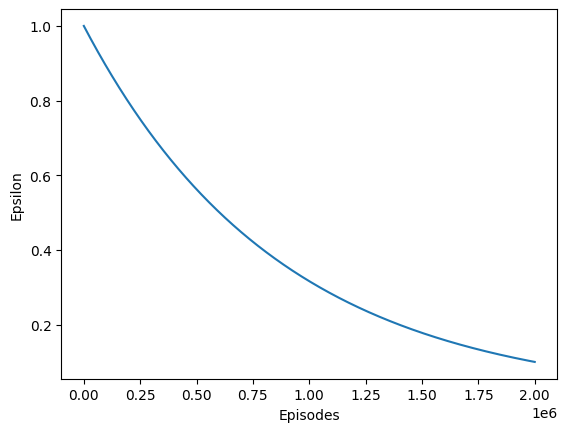

In [5]:
def display_epsilon_strategy():
    agent = RLAgent()

    epsilons = [ agent.epsilon(episode) for episode in range(agent.episodes_nb) ]

    plt.plot(epsilons)
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon")
    plt.show()

display_epsilon_strategy()

In [6]:
def display_observations(rewards, by):
    rewards_mean = [ np.mean(rewards[i : i + by]) for i in range(0, len(rewards), by) for _ in range(by) ]
    
    fig = plt.figure(1)
    plt.plot(rewards_mean)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    
    return fig

In [7]:
def train(start_episode, end_episode, update_offset):

    # initialize env
    env = create_env(show = False)

    # initialize agent
    if start_episode > 0:
        agent = RLAgent(q_table_path = f"results/q_table_e{start_episode - 1}.rl")
    else:
        agent = RLAgent(q_table_path = None)
        
    # Verify arguments validity
    assert(0 <= start_episode)
    assert(end_episode <= agent.episodes_nb)
    assert(0 < update_offset < end_episode - start_episode)

    # evaluation array
    total_rewards = list()

    for episode in tqdm(range(start_episode, end_episode + 1, 1)):

        # initialize environment
        state, _ = env.reset()
        rewards = 0
        done = False

        while not done:

            # act
            action = agent.act(env, state, episode)

            # step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # storage
            agent.train_with(state, action, reward, next_state)

            # update state, reward and steps
            state = next_state
            rewards += reward
            
        total_rewards.append(rewards)

        ## Plot reward vs episodes
        if (episode != 0 and episode % update_offset == 0):
            fig = display_observations(total_rewards[0 : episode - start_episode + 1], (end_episode - start_episode) // 25)
            fig.savefig("results/rewards.png")
            agent.save_q_table(f"results/q_table_e{episode}.rl")
    
    agent.save_q_table("results/q_table.rl")
    env.close()
    
    return agent

# agent = train(start_episode = 1000001, end_episode = 2000000, update_offset = 25000)

#### Play with our trained agent (optional)

In [8]:
agent = RLAgent("results/q_table.rl")

Loading pre-trained q_table results/q_table.rl


In [9]:
def play_with_rl(agent):
    env = create_env(show = True)

    rewards = 0
    state, _ = env.reset()
    done = False
    while not done:
        env.render()

        action = np.argmax(agent.q_table[state, :])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        rewards += reward
        state = next_state
        
    print(f"Reward is {rewards}")
    env.close()

play_with_rl(agent)

/Users/ewenbouquet/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
2024-05-23 10:14:51.182 Python[55516:1686178] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Reward is 0.0


In [10]:
pygame.quit()

: 